# MT + Transformer

In [1]:
# !pip3 install transformers[torch]

In [2]:
import torch, torchtext
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import random, math, time
from datasets import load_dataset, DatasetDict

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

/home/i7g7-1080ti/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080 Ti'

In [5]:
torch.__version__

'1.10.2+cu102'

In [6]:
torchtext.__version__

'0.11.2'

## 1. ETL: Loading the dataset

**Note**: codeparrot

In [7]:
# ds_train = load_dataset("huggingface-course/codeparrot-ds-train", split="train")
# ds_valid = load_dataset("huggingface-course/codeparrot-ds-valid", split="validation")
# import datasets
# ds_train = datasets.load_from_disk('datasets/huggingface_course_train')
# ds_valid = datasets.load_from_disk('datasets/huggingface_course_valid')

In [8]:
# print(len(ds_train),len(ds_valid))

In [9]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
# ds_train

In [10]:
# print(len(ds_train)*0.1,len(ds_valid)*1)

In [11]:
import datasets
all_set = datasets.load_from_disk('hf_course_small')
ds_train = all_set["train"]
ds_valid = all_set["valid"]

In [12]:
ds_train

Dataset({
    features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
    num_rows: 60672
})

In [13]:
ds_valid

Dataset({
    features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
    num_rows: 3322
})

In [14]:
data_column = "content"
t_ratio = 0.25
v_ratio = 1

raw_datasets = DatasetDict(
    {
        "train": ds_train.shuffle().select(range(int(len(ds_train)*t_ratio))), 
        "valid": ds_valid.shuffle().select(range(int(len(ds_valid)*v_ratio))),  
    }
)

raw_datasets

DatasetDict({
    train: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 15168
    })
    valid: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 3322
    })
})

## 2. EDA - simple investigation

In [15]:
print(raw_datasets['train'][1][data_column])

"""
Plot the decision surfaces of ensembles of trees on the iris dataset

Plot the decision surfaces of forests of randomized trees trained on pairs of
features of the iris dataset.

This plot compares the decision surfaces learned by a decision tree classifier
(first column), by a random forest classifier (second column), by an extra-
trees classifier (third column) and by an AdaBoost classifier (fourth column).

In the first row, the classifiers are built using the sepal width and the sepal
length features only, on the second row using the petal length and sepal length
only, and on the third row using the petal width and the petal length only.

In descending order of quality, when trained (outside of this example) on all
4 features using 30 estimators and scored using 10 fold cross validation, we see::

    ExtraTreesClassifier()  # 0.95 score
    RandomForestClassifier()  # 0.94 score
    AdaBoost(DecisionTree(max_depth=3))  # 0.94 score
    DecisionTree(max_depth=None)  # 0.94 scor

In [16]:
train_size = len(raw_datasets['train'])
train_size

15168

Since 29001 is plenty,, we gonna call `random_split` to train, val and test

In [17]:
from transformers import AutoTokenizer

context_length = 128
# tokenizer = AutoTokenizer.from_pretrained("huggingface-course/code-search-net-tokenizer")
tokenizer = AutoTokenizer.from_pretrained("codeparrot/codeparrot-small")

In [18]:
# make it to start + token text + stop , set <unk> = 0  '<pad>', '<sos>', '<eos>' = > 1, 2, 3

In [19]:
tokenizer.vocab_size

32768

In [20]:

stext= "import numpy as np"

In [21]:
tokens = tokenizer.tokenize(stext)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(tokens)
print(ids)

['import', 'Ġnumpy', 'Ġas', 'Ġnp']
[646, 2680, 465, 980]


In [22]:
tokens = tokenizer(stext)
nonumer = tokenizer.tokenize(stext)
print(tokens["input_ids"])
print(nonumer)
print(tokenizer.decode(tokens["input_ids"]))

[646, 2680, 465, 980]
['import', 'Ġnumpy', 'Ġas', 'Ġnp']
import numpy as np


In [23]:
bos_token_id=tokenizer.bos_token_id
bos_token_id

0

In [24]:
eos_token_id=tokenizer.eos_token_id
eos_token_id

0

In [25]:
tokenizer.all_special_ids

[0]

In [26]:
tokenizer.all_special_tokens

['<|endoftext|>']

#### add special token to tokenizer

In [27]:
special_tokens_dict = {
    'unk_token': '<unk>',
    'pad_token': '<pad>',
    'bos_token': '<sos>',
    'eos_token': '<eos>',
}
tokenizer.add_special_tokens(special_tokens_dict)

4

In [28]:
tokenizer.unk_token,tokenizer.unk_token_id

('<unk>', 32768)

In [29]:
tokenizer.pad_token,tokenizer.pad_token_id

('<pad>', 32769)

In [30]:
tokenizer.bos_token,tokenizer.bos_token_id

('<sos>', 32770)

In [31]:
tokenizer.eos_token,tokenizer.eos_token_id

('<eos>', 32771)

In [32]:
tokenizer.all_special_tokens,tokenizer.all_special_ids

(['<sos>', '<eos>', '<unk>', '<pad>'], [32770, 32771, 32768, 32769])

In [33]:
real_vocab_size = tokenizer.vocab_size + len(tokenizer.all_special_tokens)
real_vocab_size

32772

In [34]:
for num,key in enumerate(tokenizer.vocab.keys()):
  print(key," : ",tokenizer.vocab[key])
  if num == 5:
    break


Ġtwitter  :  15811
Ġwrong  :  6835
ī  :  232
nova  :  6765
ĠWhether  :  7480
Ġusable  :  18025


In [35]:
tokenizer.decode([0])

'<|endoftext|>'

In [36]:
stext = "['<sos>', '<eos>', '<unk>', '<pad>', าหนหดก ]"
# stext= "import numpy as np"

In [37]:
tokens = tokenizer(stext)
nonumer = tokenizer.tokenize(stext)
print(tokens["input_ids"])
print(nonumer)
print(tokenizer.decode(tokens["input_ids"]))

[459, 32770, 297, 283, 32771, 297, 283, 32768, 297, 283, 32769, 297, 221, 157, 117, 111, 157, 117, 105, 157, 117, 248, 157, 117, 105, 157, 117, 243, 157, 117, 224, 1622]
["['", '<sos>', "',", "Ġ'", '<eos>', "',", "Ġ'", '<unk>', "',", "Ġ'", '<pad>', "',", 'Ġ', 'à', '¸', '²', 'à', '¸', '«', 'à', '¸', 'Ļ', 'à', '¸', '«', 'à', '¸', 'Ķ', 'à', '¸', 'ģ', 'Ġ]']
['<sos>', '<eos>', '<unk>', '<pad>', าหนหดก ]


#### save if ok

In [38]:
tokenizer.save_pretrained("model/code-search-net-tokenizer-mod")

('model/code-search-net-tokenizer-mod/tokenizer_config.json',
 'model/code-search-net-tokenizer-mod/special_tokens_map.json',
 'model/code-search-net-tokenizer-mod/vocab.json',
 'model/code-search-net-tokenizer-mod/merges.txt',
 'model/code-search-net-tokenizer-mod/added_tokens.json',
 'model/code-search-net-tokenizer-mod/tokenizer.json')

In [39]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("model/code-search-net-tokenizer-mod")

#### create tokenized and numer.. dataset 

In [40]:
len(raw_datasets["train"][1][data_column])

6271

In [41]:
outputs = tokenizer(
    raw_datasets["train"][:2][data_column],
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True
)

print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

Input IDs length: 32
Input chunk lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 117, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 120]
Chunk mapping: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [42]:
print(tokenizer.decode(outputs['input_ids'][0]))

"""
Visualizing the stock market structure

This example employs several unsupervised learning techniques to extract
the stock market structure from variations in historical quotes.

The quantity that we use is the daily variation in quote price: quotes
that are linked tend to cofluctuate during a day.

.. _stock_market:

Learning a graph structure
--------------------------

We use sparse inverse covariance estimation to find which quotes are
correlated conditionally on the others. Specifically, sparse inverse
covariance gives us a graph, that is a list of


In [43]:
def tokenize(element):
    outputs = tokenizer(
        element["content"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"tokens": input_batch}


tokenized_datasets = raw_datasets.map(
    tokenize, batched=True, remove_columns=raw_datasets["train"].column_names
)
tokenized_datasets

100%|██████████| 4/4 [00:14<00:00,  3.53s/ba]


DatasetDict({
    train: Dataset({
        features: ['tokens'],
        num_rows: 421683
    })
    valid: Dataset({
        features: ['tokens'],
        num_rows: 94778
    })
})

In [44]:
samptext = tokenized_datasets["train"][0]["tokens"]
print(samptext)
print(len(samptext))
print(tokenizer.decode(samptext))

[624, 199, 2486, 18673, 199, 15039, 9147, 314, 10952, 26584, 5523, 199, 2486, 18673, 199, 199, 2765, 2893, 9052, 320, 588, 9978, 625, 4792, 17311, 9328, 32414, 83, 370, 5536, 199, 1589, 10952, 26584, 5523, 687, 4172, 1298, 315, 32530, 9344, 14, 199, 199, 1918, 12524, 626, 781, 675, 365, 314, 26122, 29844, 315, 6313, 8033, 26, 9344, 199, 9099, 787, 10632, 221, 7169, 370, 512, 2327, 918, 4767, 5309, 282, 5382, 14, 199, 199, 703, 485, 6088, 63, 22270, 26, 199, 199, 25519, 282, 3343, 5523, 199, 777, 9460, 199, 199, 6004, 675, 5178, 11484, 13263, 27156, 370, 2342, 1314, 9344, 787, 199, 989, 2407, 5558, 1183, 641, 314, 11789, 14, 30836, 12, 5178, 11484, 199, 15024, 10557, 2739, 282, 3343, 12, 626, 365, 282, 769, 402]
128
"""
Visualizing the stock market structure

This example employs several unsupervised learning techniques to extract
the stock market structure from variations in historical quotes.

The quantity that we use is the daily variation in quote price: quotes
that are linked tend 

#### save dataset 

In [45]:
disk_spath = 'tokenized_dataset_dict'

tokenized_datasets.save_to_disk(disk_spath)

In [46]:
import datasets
disk_lpath = 'tokenized_dataset_dict'
tokenized_datasets = datasets.load_from_disk(disk_lpath)

In [47]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['tokens'],
        num_rows: 421683
    })
    valid: Dataset({
        features: ['tokens'],
        num_rows: 94778
    })
})

In [48]:
print(tokenizer.decode(tokenized_datasets['train'][0]['tokens']))


"""
Visualizing the stock market structure

This example employs several unsupervised learning techniques to extract
the stock market structure from variations in historical quotes.

The quantity that we use is the daily variation in quote price: quotes
that are linked tend to cofluctuate during a day.

.. _stock_market:

Learning a graph structure
--------------------------

We use sparse inverse covariance estimation to find which quotes are
correlated conditionally on the others. Specifically, sparse inverse
covariance gives us a graph, that is a list of


## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

#### edit from transformers data loader 

collatch batch  
1. loop load sample from batch  
2. tokenize  
3. numericalize  
4. add start token and stop token   
5. feed to pad_sequence   
6. output

but our dataset already do 2,3 then we do 1 -> 4 -> 5 -> 6 and we only need trg dataset for decoder 

In [49]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

SOS_IDX = tokenizer.bos_token_id
EOS_IDX = tokenizer.eos_token_id
PAD_IDX = tokenizer.pad_token_id
# function to collate data samples into batch tesors
def collate_batch(batch):
    trg_batch = []
    for  trg_sample in batch:
        added_sample = torch.cat((torch.tensor([SOS_IDX]) , torch.tensor(trg_sample) , torch.tensor([EOS_IDX])))
        trg_batch.append(added_sample)

    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    
    return trg_batch

Create train, val, and test dataloaders

In [50]:
batch_size = 128
tokenized_datasets["train"]
train_loader = DataLoader(tokenized_datasets["train"]["tokens"], batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(tokenized_datasets["valid"]["tokens"], batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)

Let's test the train loader.

In [51]:
# actually it no need to pad because all data if equal to 128 from start 
for i,sample in enumerate(train_loader):

  if PAD_IDX in sample:
    print("i found pad")
    break    
 
  if sample.shape[1] != 130:
    print("something wrong with data")
    break

i found pad


In [52]:
print("sample shape: ", sample.shape,"sample data: ",sample)  # (batch_size, seq len)

sample shape:  torch.Size([128, 130]) sample data:  tensor([[32770,   327,   314,  ...,   327,  1379, 32771],
        [32770,   272,   892,  ...,    29,  1222, 32771],
        [32770,    87, 23919,  ...,  5350,    63, 32771],
        ...,
        [32770,   435,  7596,  ...,    12,   980, 32771],
        [32770,   199,  9218,  ...,   509,   284, 32771],
        [32770,    63,  1267,  ...,  1370,   908, 32771]])


## 5. Design the model



### Mutli Head Attention Layer

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

This is similar to standard *dot product attention* but is scaled by $d_k$, which the paper states is used to stop the results of the dot products growing large, causing gradients to become too small.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$ is the linear layer applied at the end of the multi-head attention layer, `fc`. $W^Q, W^K, W^V$ are the linear layers `fc_q`, `fc_k` and `fc_v`.

In [53]:
class MultiHeadAttentionLayer(nn.Module):
    
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads  #make sure it's divisible....
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc   = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.scale   = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, q, k, v, mask = None):
        b = q.shape[0]
        
        Q = self.fc_q(q)
        K = self.fc_k(k)
        V = self.fc_v(v)
        #Q, K, V = [b, l, h]
        
        #reshape them into head_dim
        #reshape them to [b, n_heads, l, head_dim]
        Q = Q.view(b, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(b, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(b, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q, K, V = [b, n_heads, l, head_dim]
        
        #e = QK/sqrt(dk)
        e = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #e: [b, n_heads, ql, kl]
        
        if mask is not None:
            e = e.masked_fill(mask == 0, -1e10)
            
        a = torch.softmax(e, dim=-1)
        
        #eV
        x = torch.matmul(self.dropout(a), V)
        #x: [b, n_heads, ql, head_dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        #x: [b, ql, n_heads, head_dim]
        
        #concat them together
        x = x.view(b, -1, self.hid_dim)
        #x: [b, ql, h]
        
        x = self.fc(x)
        #x = [b, ql, h]
        
        return x, a
        

### Position-wise Feedforward Layer

In [54]:
class PositionwiseFeedforwardLayer(nn.Module):
    
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.fc2(self.dropout(torch.relu(self.fc1(x))))

#### beam node


In [55]:
class BeamSearchNode(object):
    def __init__(self,  previousNode, wordId, logProb, length):
        # self.h        = hiddenstate  #define the hidden state
        self.prevNode = previousNode  #where does it come from
        self.wordid   = wordId  #the numericalized integer of the word
        self.logp     = logProb  #the log probability
        self.len      = length  #the current length; first word starts at 1

    def eval(self, alpha=0.7):
        # the score will be simply the log probability penaltized by the length 
        # we add some small number to avoid division error
        # read https://arxiv.org/abs/1808.10006 to understand how alpha is selected
        return self.logp / float(self.len + 1e-6) ** (alpha)
    
    #this is the function for comparing between two beamsearchnodes, whether which one is better
    #it is called when you called "put"
    def __lt__(self, other):
        return self.len < other.len

    def __gt__(self, other):
        return self.len > other.len

### Decoder

In [56]:
torch.cuda.empty_cache()

In [57]:
from queue import PriorityQueue
import operator

class Decoder(nn.Module):
    
    def __init__(self, output_dim, hid_dim, n_layers, n_heads,
                 pf_dim, dropout, device,trg_pad_idx, max_length = 130):
        super().__init__()
        self.trg_pad_idx = trg_pad_idx
        self.pos_emb = nn.Embedding(max_length, hid_dim)
        self.trg_emb = nn.Embedding(output_dim, hid_dim)
        self.scale   = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        self.dropout = nn.Dropout(dropout)
        self.layers  = nn.ModuleList(
                     [
                        DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                        for _ in range(n_layers)
                     ]
                     )
        self.fc      = nn.Linear(hid_dim, output_dim)
        self.device  = device
    
    def make_trg_mask(self, trg):
        
        trg_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_mask: [b, 1, 1, l]
        
        trg_len = trg_mask.shape[-1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        trg_mask = trg_mask & trg_sub_mask
        #trg_mask: [b, 1, l, l]
        
        return trg_mask

    def forward(self, trg):
        #trg = [b, tl]
        #enc_src = hidden states from encoder = [b, sl, h]
        #trg_mask = [b, 1, tl, tl]
        #src_mask = [b, 1, 1, sl]

        # create trg mask inside
        trg_mask = self.make_trg_mask(trg)

        b = trg.shape[0]
        l = trg.shape[1]
        
        #pos
        pos = torch.arange(0, l).unsqueeze(0).repeat(b, 1).to(self.device)
        #pos: [b, l]
        
        pos_emb = self.pos_emb(pos) #[b, l, h]
        trg_emb = self.trg_emb(trg) #[b, l, h]
        
        x = pos_emb + trg_emb * self.scale #[b, l, h]
        x = self.dropout(x)
        
        for layer in self.layers:
            trg = layer(x, trg_mask)

        # print(trg.shape)
        
        output = self.fc(trg)
        
        return output

    def decode(self, trg, method='beam-search'):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #src len = [batch size]

        # encoder_outputs, hidden = self.encoder(src, src_len) 
        #encoder_outputs = [src len, batch size, hid dim * 2]  (*2 because of bidirectional)(every hidden states)
        #hidden = [batch size, hid dim]  #final hidden state
       
        # hidden = hidden.unsqueeze(0)
        #hidden = [1, batch size, hid dim]
        
        if method == 'beam-search':
            return self.beam_decode(trg)
        else:
            return self.greedy_decode(trg)


    def greedy_decode(self, trg):

        prediction= self.forward(trg)
        prediction = prediction.squeeze(0)
        prediction = prediction[1:] # not include first one? 
        prediction = prediction.argmax(1) 

        return prediction


    def beam_decode(self,target_tensor):
        # remove ---
        #src_tensor      = [src len, batch size]---
        #target_tensor   = [trg len, batch size]
        #decoder_hiddens = [1, batch size, hid dim]---
        #encoder_outputs = [src len, batch size, hid dim * 2]---
        
        target_tensor = target_tensor.permute(1, 0)
        #target_tensor = [batch size, trg len]
        
        #how many parallel searches
        beam_width = 3
        
        #how many sentence do you want to generate
        topk = 1  
        
        #final generated sentence
        decoded_batch = []
                
        #Another difference is that beam_search_decoding has 
        #to be done sentence by sentence, thus the batch size is indexed and reduced to only 1.  
        #To keep the dimension same, we unsqueeze 1 dimension for the batch size.
        for idx in range(target_tensor.size(0)):  # batch_size
            
            #decoder_hiddens = [1, batch size, dec hid dim]
            # decoder_hidden = decoder_hiddens[:, idx, :]
            #decoder_hidden = [1, dec hid dim]

            # Start with the start of the sentence token
            decoder_input = torch.LongTensor([SOS_IDX]).to(device)

            # Number of sentence to generate
            endnodes = []  #hold the nodes of EOS, so we can backtrack
            number_required = min((topk + 1), topk - len(endnodes))

            # starting node -  hidden vector, previous node, word id, logp, length
            node = BeamSearchNode( None, decoder_input, 0, 1)
            nodes = PriorityQueue()  #this is a min-heap

            # start the queue
            nodes.put((-node.eval(), node))  #we need to put - because PriorityQueue is a min-heap
            qsize = 1

            # start beam search
            while True:
                # give up when decoding takes too long
                if qsize > 2000: break

                # fetch the best node
                # score is log p divides by the length scaled by some constants
                score, n = nodes.get()
          
                # wordid is simply the numercalized integer of the word
                decoder_input  = n.wordid
                # decoder_hidden = n.h

                if n.wordid.item() == EOS_IDX and n.prevNode != None:
                    endnodes.append((score, n))
                    # if we reached maximum # of sentences required
                    if len(endnodes) >= number_required:
                        break
                    else:
                        continue

                # decode for one step using decoder
                # decoder_input = SOS_IDX
                # decoder_hidden = [1, hid dim]


                prediction = self.forward(decoder_input.reshape(1,-1))
                #prediction     = [1, output dim]  #1 because the batch size is 1
                prediction = prediction.squeeze(0)

                #so basically prediction is probabilities across all possible vocab
                #we gonna retrieve k top probabilities (which is defined by beam_width) and their indexes
                #recall that beam_width defines how many parallel searches we want
                log_prob, indexes = torch.topk(prediction, beam_width)

                # log_prob      = (1, beam width)
                # indexes       = (1, beam width)
                
                nextnodes = []  #the next possible node you can move to

                # we only select beam_width amount of nextnodes
                for top in range(beam_width):
                    pred_t = indexes[0, top].reshape(-1)  #reshape because wordid is assume to be []; see when we define SOS
                    log_p = log_prob[0, top].item()
                                    
                    #decoder hidden, previous node, current node, prob, length
                    node = BeamSearchNode( n, pred_t, n.logp + log_p, n.len + 1)
                    score = -node.eval()
                    nextnodes.append((score, node))

                # put them into queue
                for i in range(len(nextnodes)):
                    score, nn = nextnodes[i]
                    nodes.put((score, nn))
                    # increase qsize
                qsize += len(nextnodes) - 1

            # Once everything is finished, choose nbest paths, back trace them
            
            ## in case it does not finish, we simply get couple of nodes with highest probability
            if len(endnodes) == 0:
                endnodes = [nodes.get() for _ in range(topk)]

            #look from the end and go back....
            utterances = []
            for score, n in sorted(endnodes, key=operator.itemgetter(0)):
                utterance = []
                utterance.append(n.wordid)
                # back trace by looking at the previous nodes.....
                while n.prevNode != None:
                    n = n.prevNode
                    utterance.append(n.wordid)

                utterance = utterance[::-1]  #reverse it....
                utterances.append(utterance) #append to the list of sentences....

            decoded_batch.append(utterances)

        return decoded_batch  #(batch size, length)
        

### Decoder Layer

<img src = "../figures/transformer-decoder.png" >


In [59]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        
        self.norm_att = nn.LayerNorm(hid_dim) #second green box
        self.norm_ff  =  nn.LayerNorm(hid_dim) #third green box
        self.norm_maskedatt =  nn.LayerNorm(hid_dim) #first green box

        self.multi_masked  =  MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        # self.multi_cross   =  MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)

        self.ff      =  PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout =  nn.Dropout(dropout)
        
    def forward(self, trg, trg_mask):
        #trg: [b, tl, h]
        #enc_src: [b, sl, h]
        #trg_mask: [b, 1, tl, tl]
        #src_mask: [b, 1, 1, sl]
        
        #first block
        _trg, _ = self.multi_masked(trg, trg, trg, trg_mask) #q, k, v
        _trg    = self.dropout(_trg)
        _trg    = trg + _trg
        trg     = self.norm_maskedatt(_trg)
        
        # #second block
        # _trg, attention = self.multi_cross(trg, enc_src, enc_src, src_mask) #q, k, v
        # _trg    = self.dropout(_trg)
        # _trg    = trg + _trg
        # trg     = self.norm_att(_trg)
        
        #third block
        _trg    = self.ff(trg)
        _trg    = self.dropout(_trg)
        _trg    = trg + _trg
        trg     = self.norm_ff(_trg)
        
        return trg


        

### Putting them together (become Seq2Seq!)

Finally, we have the `Seq2Seq` module which encapsulates the encoder and decoder, as well as handling the creation of the masks.

The source mask is created by checking where the source sequence is not equal to a `<pad>` token. It is 1 where the token is not a `<pad>` token and 0 when it is. It is then unsqueezed so it can be correctly broadcast when applying the mask to the `energy`, which of shape `[batch size, n heads, seq len, seq len]`.

The target mask is slightly more complicated. First, we create a mask for the `<pad>` tokens, as we did for the source mask. Next, we create a "subsequent" mask, `trg_sub_mask`, using `torch.tril`. This creates a diagonal matrix where the elements above the diagonal will be zero and the elements below the diagonal will be set to whatever the input tensor is. In this case, the input tensor will be a tensor filled with ones. So this means our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

This shows what each target token (row) is allowed to look at (column). The first target token has a mask of `[1, 0, 0, 0, 0]` which means it can only look at the first target token. The second target token has a mask of `[1, 1, 0, 0, 0]` which it means it can look at both the first and second target tokens. 

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

After the masks are created, they used with the encoder and decoder along with the source and target sentences to get our predicted target sentence, `output`, along with the decoder's attention over the source sequence.

In [60]:
trg_sub_mask = torch.tril(torch.ones((3, 3))).bool()
trg_sub_mask

tensor([[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True]])

In [61]:
trg_mask = torch.LongTensor([1, 1, 0])
trg_mask  #(l, )

tensor([1, 1, 0])

In [62]:
trg_mask = trg_mask.unsqueeze(0).unsqueeze(1).unsqueeze(2)
trg_mask.shape #(b, 1, 1, l)

torch.Size([1, 1, 1, 3])

In [63]:
trg_mask & trg_sub_mask

tensor([[[[1, 0, 0],
          [1, 1, 0],
          [1, 1, 0]]]])

## 6. Training

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

In [64]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [65]:
OUTPUT_DIM = tokenizer.vocab_size + len(tokenizer.all_special_tokens)
HID_DIM = 256

DEC_LAYERS = 3

DEC_HEADS = 8

DEC_PF_DIM = 512

DEC_DROPOUT = 0.37

TRG_PAD_IDX = PAD_IDX

model = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              TRG_PAD_IDX)


model.to(device)

model.apply(initialize_weights)

Decoder(
  (pos_emb): Embedding(130, 256)
  (trg_emb): Embedding(32772, 256)
  (dropout): Dropout(p=0.37, inplace=False)
  (layers): ModuleList(
    (0): DecoderLayer(
      (norm_att): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm_ff): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm_maskedatt): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (multi_masked): MultiHeadAttentionLayer(
        (fc_q): Linear(in_features=256, out_features=256, bias=True)
        (fc_k): Linear(in_features=256, out_features=256, bias=True)
        (fc_v): Linear(in_features=256, out_features=256, bias=True)
        (fc): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.37, inplace=False)
      )
      (ff): PositionwiseFeedforwardLayer(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.37, inplace=False)
    

In [66]:
params_path = "model/param.pt"

params = {"OUTPUT_DIM":OUTPUT_DIM,"HID_DIM":HID_DIM ,"DEC_LAYERS":DEC_LAYERS,"DEC_HEADS":DEC_HEADS
           ,"DEC_PF_DIM":DEC_PF_DIM,"DEC_DROPOUT" :DEC_DROPOUT, "TRG_PAD_IDX":TRG_PAD_IDX}
torch.save(params,params_path)

In [67]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

 33280
8389632
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
8389632
 32772
______
18428164


The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

In [68]:
import torch.optim as optim

lr = 0.0001

#training hyperparameters
optimizer = optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

In [69]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for trg in loader:
        
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        # include eos to make model know when to stop
        output = model(trg[:,:-1])  
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1)    #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
              
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [70]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for trg in loader:
        
            # src = src.to(device)
            trg = trg.to(device)

            output = model(trg[:,:-1])# input trg not include eos
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1) # compare not include sos and eos 

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [71]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))

In [72]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [73]:
best_valid_loss = float('inf')
num_epochs = 50
clip       = 1
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)

save_path = f'model/best_{model.__class__.__name__}.pt'
last_path = f'model/last_{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

begin_time = time.time()
limit_time = 5 #hr
limit_time = limit_time*60*60

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    lr_scheduler.step(valid_loss)

    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)

    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    if limit_time < (time.time()-begin_time):
        print("limit time stop!")
        break

used_time = (time.time()-begin_time)
if used_time > 3600:
    print(f"used time: {(used_time/360):.2f} hr")
elif used_time > 60:
    print(f"used time: {(used_time/60):.2f} min")
else:
    print(f"used time: {used_time:.2f} s")

torch.save(model.state_dict(), last_path)
    
#lower perplexity is better

Epoch: 01 | Time: 13m 40s
	Train Loss: 5.050 | Train PPL: 155.959
	 Val. Loss: 4.239 |  Val. PPL:  69.371
Epoch: 02 | Time: 13m 39s
	Train Loss: 4.049 | Train PPL:  57.369
	 Val. Loss: 3.888 |  Val. PPL:  48.809
Epoch: 03 | Time: 13m 40s
	Train Loss: 3.825 | Train PPL:  45.821
	 Val. Loss: 3.733 |  Val. PPL:  41.806
Epoch: 04 | Time: 13m 39s
	Train Loss: 3.707 | Train PPL:  40.738
	 Val. Loss: 3.634 |  Val. PPL:  37.882
Epoch: 05 | Time: 13m 39s
	Train Loss: 3.633 | Train PPL:  37.815
	 Val. Loss: 3.567 |  Val. PPL:  35.406
Epoch: 06 | Time: 13m 39s
	Train Loss: 3.581 | Train PPL:  35.918
	 Val. Loss: 3.521 |  Val. PPL:  33.803
Epoch: 07 | Time: 13m 39s
	Train Loss: 3.543 | Train PPL:  34.563
	 Val. Loss: 3.484 |  Val. PPL:  32.584
Epoch: 08 | Time: 13m 38s
	Train Loss: 3.513 | Train PPL:  33.547
	 Val. Loss: 3.456 |  Val. PPL:  31.694
Epoch: 09 | Time: 13m 39s
	Train Loss: 3.489 | Train PPL:  32.750
	 Val. Loss: 3.432 |  Val. PPL:  30.925
Epoch: 10 | Time: 13m 39s
	Train Loss: 3.469 |

In [74]:
! nvidia-smi

Sun Mar 12 18:12:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 83%   71C    P2    79W / 280W |  10380MiB / 11264MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Text(0, 0.5, 'loss')

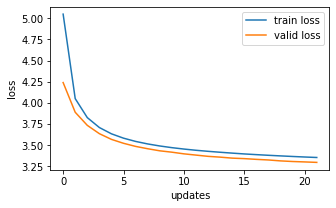

In [75]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

#### test is not avilable at this moment

In [76]:
# model.load_state_dict(torch.load(save_path))
# test_loss = evaluate(model, test_loader, criterion, test_loader_length)

# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

## 7. Test on some 

In [77]:
tokenizer.bos_token_id

32770

In [78]:
tokenizer.pad_token_id

32769

In [79]:
for trg in train_loader:
  print(trg,trg.shape)
  break

tensor([[32770,    12,   612,  ...,    12,  1568, 32771],
        [32770,    63,  6376,  ...,   367,   286, 32771],
        [32770,     8,    43,  ..., 18644,   304, 32771],
        ...,
        [32770,  7619,   878,  ...,   304,   272, 32771],
        [32770,    12,  1305,  ...,  4097,     8, 32771],
        [32770, 27066,    70,  ...,   282,  8626, 32771]]) torch.Size([128, 130])


In [80]:
trg_text = "import matplotlib.pyplot "
trg_text = tokenizer(trg_text)

# not sure which one
trg =torch.LongTensor([tokenizer.bos_token_id]+trg_text["input_ids"]).reshape(1,-1)
# trg = torch.LongTensor(trg_text["input_ids"]).reshape(1,-1)

In [81]:
trg.shape

torch.Size([1, 6])

In [82]:
trg = trg.reshape(1,-1).to(device)

In [83]:
model.eval()
with torch.no_grad():
    output= model(trg)
output

tensor([[[-13.6615,  -1.8299,   0.9545,  ..., -13.5980, -13.6884,  -7.9335],
         [-15.9618,  -2.4985,   0.1374,  ..., -16.0245, -15.8458, -10.6362],
         [-20.7567,  -1.4211,   2.9297,  ..., -21.0997, -20.5672, -10.7560],
         [-17.9051,  -4.2522,  -7.3941,  ..., -18.3532, -17.9987, -11.8675],
         [-19.7063,   1.1738,   3.3301,  ..., -19.8700, -19.2008,  -5.9469],
         [-15.2330,  -1.7193,  -2.3224,  ..., -15.9639, -15.4645,  -8.0153]]],
       device='cuda:0')

In [84]:
output.squeeze(0).shape

torch.Size([6, 32772])

In [85]:
output,output.shape

(tensor([[[-13.6615,  -1.8299,   0.9545,  ..., -13.5980, -13.6884,  -7.9335],
          [-15.9618,  -2.4985,   0.1374,  ..., -16.0245, -15.8458, -10.6362],
          [-20.7567,  -1.4211,   2.9297,  ..., -21.0997, -20.5672, -10.7560],
          [-17.9051,  -4.2522,  -7.3941,  ..., -18.3532, -17.9987, -11.8675],
          [-19.7063,   1.1738,   3.3301,  ..., -19.8700, -19.2008,  -5.9469],
          [-15.2330,  -1.7193,  -2.3224,  ..., -15.9639, -15.4645,  -8.0153]]],
        device='cuda:0'),
 torch.Size([1, 6, 32772]))

In [86]:
with torch.no_grad():
  greedy = model.greedy_decode(trg)

In [87]:
tokenizer.decode(greedy)

' numpy.pyplot as #'

In [88]:
trg.reshape(1,-1).shape

torch.Size([1, 6])

In [89]:
trg

tensor([[32770,   646,  8027,    14, 13563,   221]], device='cuda:0')

In [90]:
with torch.no_grad():
  beamy = model.beam_decode(trg)


In [91]:
result0 = torch.tensor(beamy[1]).squeeze(0)

In [92]:
tokenizer.decode(result0)
# I don't know 

'<sos>__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

In [93]:

# def give_shit(prompt, max_seq_len, temperature, model, tokenizer, vocab, device, seed=None):
#     if seed is not None:
#         torch.manual_seed(seed)
#     model.eval()
#     tokens = tokenizer(prompt)
#     indices = [vocab[t] for t in tokens]
#     batch_size = 1
#     hidden = model.init_hidden(batch_size, device)
#     with torch.no_grad():
#         for i in range(max_seq_len):
#             src = torch.LongTensor([indices]).to(device)
#             prediction, hidden = model(src, hidden)
            
#             #prediction: [batch size, seq len, vocab size]
#             #prediction[:, -1]: [batch size, vocab size] #probability of last vocab
            
#             probs = torch.softmax(prediction[:, -1] / temperature, dim=-1)  
#             prediction = torch.multinomial(probs, num_samples=1).item()    
            
#             while prediction == vocab['<unk>']: #if it is unk, we sample again
#                 prediction = torch.multinomial(probs, num_samples=1).item()

#             if prediction == vocab['<eos>']:    #if it is eos, we stop
#                 break

#             indices.append(prediction) #autoregressive, thus output becomes input

#     itos = vocab.get_itos()
#     tokens = [itos[i] for i in indices]
#     return tokens


# print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))